In [1]:
import os, sys
import json
import jsonlines
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import cohere
import requests
import base64
import pickle
import torch

from collections import defaultdict

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/samuelcahyawijaya_cohere_com/.config/sagemaker/config.yaml


In [2]:
# Init Cohere API
co = cohere.ClientV2(
    base_url="https://stg.api.cohere.com", 
    api_key=os.getenv("CO_API_KEY_STAGING")
)

In [3]:
# Read raw data
test_data_dict = {}
docs_data_dict = {}
for path in glob('/home/samuelcahyawijaya_cohere_com/repos_v3/retrieval-augmentation/repairbench/annotated_data/*.json'):
    dset = pd.read_json(path)
    dset_name = path.split('/')[-1].replace('.json', '')
    test_data_dict[dset_name] = dset
    print(f"Loading `{dset_name}` with {len(dset)} data points.")

    # Read context documents
    docs_data = []
    for path in glob(f'/home/samuelcahyawijaya_cohere_com/repos_v3/retrieval-augmentation/repairbench/{dset_name}_docs/*'):
        json_data = json.load(open(path, 'r'))
        for i in range(len(json_data)):
            json_data[i]['metadata']['chunk_idx'] = i+1
        docs_data += json_data

    docs_data_dict[dset_name] = docs_data
    print(f'Loaded {len(docs_data)} document chunks for `{dset_name}`')
    print()

Loading `repairbench_ko` with 55 data points.
Loaded 162 document chunks for `repairbench_ko`

Loading `repairbench_en` with 373 data points.
Loaded 2224 document chunks for `repairbench_en`

Loading `repairbench_ja` with 116 data points.
Loaded 1429 document chunks for `repairbench_ja`



# Reranker Evaluation

In [18]:
# Reranker Evaluation Params
# test_data_dict: Dict<dataset_name, annotated_data_df>

ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
eval_dict = {}
for dset_name, test_df in test_data_dict.items():
    print(f'Running Rerank Evaluation for `{dset_name}`')
    docs_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0]]).tolist()
    silver_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0] if res['is_relevant'] in ['1', '2']]).tolist()
    gold_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0] if res['is_relevant'] in ['2']]).tolist()
    
    docs_list = test_df['data'].apply(lambda x: [res['snippet'] for res in x['search_results'][0]]).tolist()
    query_list = test_df['data'].apply(lambda x: x['question']).tolist()

    k_metrics = {
        k: {'silver_correct': 0, 'silver_count': 0, 'gold_correct': 0, 'gold_count': 0} for k in ks
    }
    sum_metrics = {}
    for query, docs, docs_uids, silver_uids, gold_uids in tqdm(zip(query_list, docs_list, docs_uids_list, silver_uids_list, gold_uids_list)):
        # Compute Rerank from top-15 search results
        response = co.rerank(
            model="rerank-v3.5",
            query=query,
            documents=docs,
            top_n=15
        )
        rerank_uids = [docs_uids[res.index] for res in response.results]
    
        for k in ks:
            pred_uids = [uid for uid in rerank_uids[:k]]
            if len(silver_uids) > 0:
                k_metrics[k][f'silver_correct'] += len(set(pred_uids).intersection(set(silver_uids)))
                k_metrics[k][f'silver_count'] += len(set(silver_uids))
            if len(gold_uids) > 0:
                k_metrics[k][f'gold_correct'] += len(set(pred_uids).intersection(set(gold_uids)))
                k_metrics[k][f'gold_count'] += len(set(gold_uids))
            
    for k in ks:
        sum_metrics[k] = {
            'silver_acc': k_metrics[k][f'silver_correct'] / k_metrics[k][f'silver_count'], 
            'gold_acc': k_metrics[k][f'gold_correct'] /k_metrics[k][f'gold_count'],
        }

    eval_dict[dset_name] = dict(sum_metrics)

Running Rerank Evaluation for `repairbench_ko`


55it [00:06,  8.15it/s]


Running Rerank Evaluation for `repairbench_en`


373it [00:48,  7.64it/s]


Running Rerank Evaluation for `repairbench_ja`


116it [00:13,  8.37it/s]


In [19]:
json.dump(eval_dict, open('eval_reranker.json', 'w'))

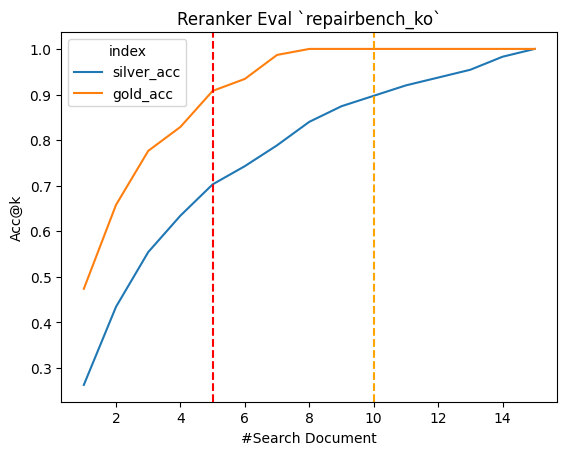

In [20]:
dset_name = 'repairbench_ko'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Reranker Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=5, ymin=0, ymax=1, color='red', linestyle='--')
plt.axvline(x=10, ymin=0, ymax=1, color='orange', linestyle='--')
plt.show()

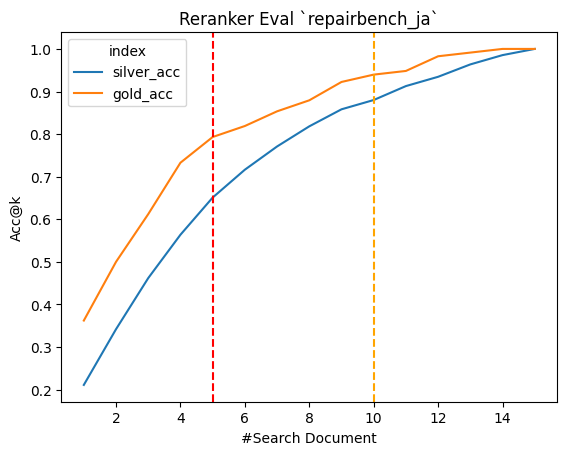

In [21]:
dset_name = 'repairbench_ja'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Reranker Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=5, ymin=0, ymax=1, color='red', linestyle='--')
plt.axvline(x=10, ymin=0, ymax=1, color='orange', linestyle='--')
plt.show()

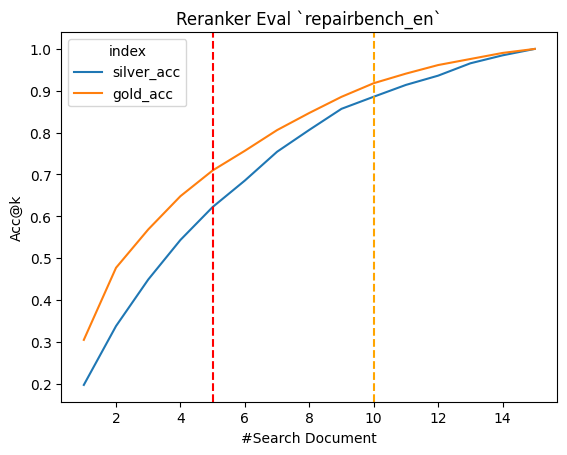

In [22]:
dset_name = 'repairbench_en'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Reranker Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=5, ymin=0, ymax=1, color='red', linestyle='--')
plt.axvline(x=10, ymin=0, ymax=1, color='orange', linestyle='--')
plt.show()